# OpenSearch Vendor Analysis - Simplified

Quick vendor analysis dashboard for OpenSearch logs.

In [1]:
# Setup - Run this first
import sys, os, json, pandas as pd, warnings
warnings.filterwarnings('ignore')
sys.path.append('src')

from opensearch_client import OpenSearchClient
from opensearch_query_builder import OpenSearchQueryBuilder  
from visualization import VendorVisualizer

# Auto-connect to local OpenSearch
client = OpenSearchClient(base_url="http://localhost:9200", auth_type="none")
query_builder = OpenSearchQueryBuilder()
visualizer = VendorVisualizer()

print("✅ Connected to OpenSearch")
health = client.validate_connection()
if health['valid']:
    print(f"✅ Cluster: {health['cluster_name']} ({health['status']})")
else:
    print(f"❌ Connection failed: {health['message']}")

✅ Connected to OpenSearch
✅ Cluster: opensearch-cluster (green)


In [2]:
# Execute Vendor Analysis
print("🔍 Analyzing vendor logs...")

# Build and execute query
query = query_builder.build_term_based_vendor_query(["logs-*"], "-24h@h")
raw_response = client.client.search(body=query, index="logs-*", timeout=120)

# Process results
results = query_builder.extract_vendor_products(raw_response)
stats = query_builder.generate_summary_stats(results)

print(f"✅ Found {len(results)} vendors in {stats['total_events']:,} events")
print(f"🔝 Top vendor: {stats['top_vendor']} ({stats['top_vendor_count']:,} events)")

🔍 Analyzing vendor logs...
✅ Found 9 vendors in 18,750 events
🔝 Top vendor: Palo Alto (2,146 events)


## 📊 Vendor Analysis Results

In [3]:
# Display results table
print("📋 VENDOR ANALYSIS TABLE")
print("=" * 80)
display(results)

📋 VENDOR ANALYSIS TABLE


,vendor_product,count,percentage,category,sourcetype,index
0,Palo Alto,2146,11.45,Network Security,logs-2025.08.22,logs-2025.08.22
1,Fortinet,2143,11.43,Network Security,logs-2025.08.22,logs-2025.08.22
2,Microsoft,2124,11.33,Microsoft,logs-2025.08.22,logs-2025.08.22
3,Juniper,2110,11.25,Network Security,logs-2025.08.22,logs-2025.08.22
4,Cisco,2089,11.14,Network Security,logs-2025.08.22,logs-2025.08.22
5,Checkpoint,2044,10.90,Network Security,logs-2025.08.22,logs-2025.08.22
6,Aws,2043,10.90,Cloud - AWS,logs-2025.08.22,logs-2025.08.22
7,Vmware,2035,10.85,Virtualization,logs-2025.08.22,logs-2025.08.22
8,F5,2016,10.75,Load Balancer,logs-2025.08.22,logs-2025.08.22


📊 VENDOR DISTRIBUTION


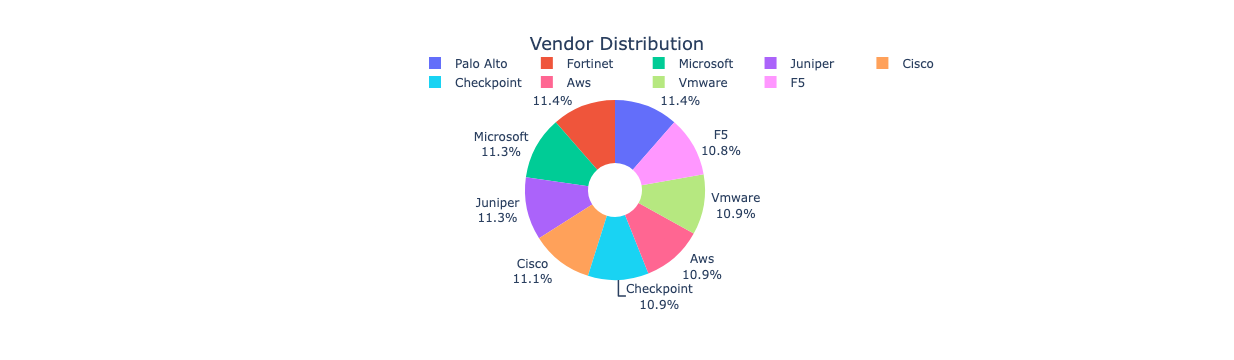

In [4]:
# Show vendor distribution chart
print("📊 VENDOR DISTRIBUTION")
fig = visualizer.create_vendor_distribution_pie(results, "Vendor Distribution")
fig.show()

📂 CATEGORY BREAKDOWN


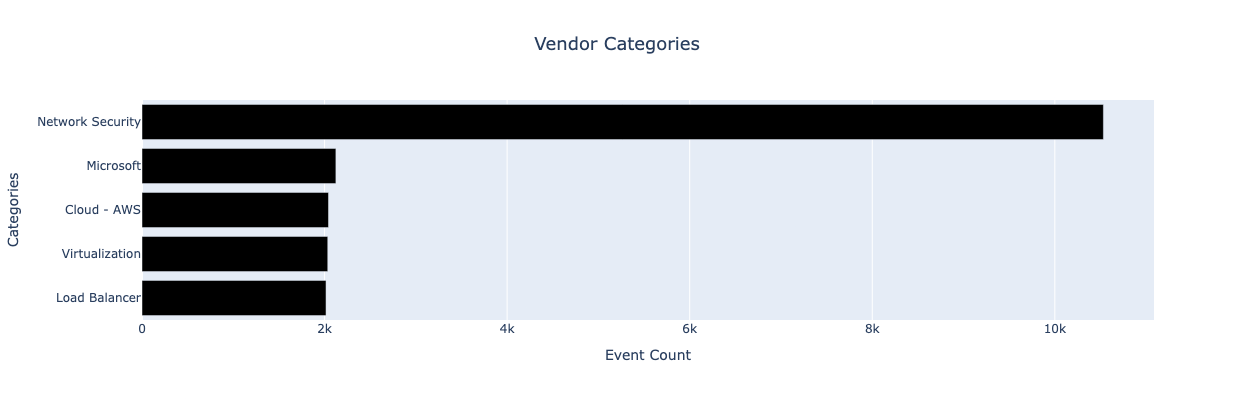

In [5]:
# Show category breakdown
print("📂 CATEGORY BREAKDOWN") 
fig = visualizer.create_category_breakdown(results, "Vendor Categories")
fig.show()

In [ ]:
# Summary Dashboard
print("📈 SUMMARY DASHBOARD")
gap_results = query_builder.identify_coverage_gaps(results, [
    "Cisco", "Palo Alto", "Fortinet", "Checkpoint", "Juniper", 
    "F5", "Microsoft", "Vmware", "Aws"
])

fig = visualizer.create_summary_dashboard(results, gap_results, stats)
fig.show()

## 📋 Summary Statistics

In [ ]:
# Print detailed summary
print("🎯 OPENSEARCH VENDOR ANALYSIS SUMMARY")
print("=" * 60)
print(f"📊 Total Vendors: {stats['total_vendors']}")
print(f"📈 Total Events: {stats['total_events']:,}")
print(f"🔝 Top Vendor: {stats['top_vendor']} ({stats['top_vendor_count']:,} events)")

print("\n📂 By Category:")
for category, count in sorted(stats['categories'].items(), key=lambda x: x[1], reverse=True):
    pct = (count / stats['total_events']) * 100
    print(f"   {category}: {count:,} events ({pct:.1f}%)")

print("\n🔍 Gap Analysis:")
missing = gap_results[gap_results['status'] == 'Missing']
present = gap_results[gap_results['status'] == 'Present']
print(f"   ✅ Present: {len(present)} vendors")
print(f"   ❌ Missing: {len(missing)} vendors")
if len(missing) > 0:
    print(f"   📋 Missing: {', '.join(missing['vendor_product'])}")

print("\n💾 Export:")
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
csv_path = visualizer.export_to_csv(results, f"opensearch_analysis_{timestamp}")
print(f"✅ Results exported to: {csv_path}")